# Simple guide to GAN network

In [1]:
%cd /content/drive/MyDrive/딥러닝기초

/content/drive/MyDrive/딥러닝기초


In [2]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from tensorflow.keras import layers
import tensorflow
from IPython import display

## Data Upload

In [3]:
# 케라스의의 load_data() 내부

'''def load_data(path='mnist.npz'):
    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz', file_hash='8a61469f7ea1b51cbae51d4f78837e45')
    with np.load(path, allow_pickle=True) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
    return (x_train, y_train), (x_test, y_test)'''

"def load_data(path='mnist.npz'):\n    path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz', file_hash='8a61469f7ea1b51cbae51d4f78837e45')\n    with np.load(path, allow_pickle=True) as f:\n        x_train, y_train = f['x_train'], f['y_train']\n        x_test, y_test = f['x_test'], f['y_test']\n    return (x_train, y_train), (x_test, y_test)"

In [4]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
train_images.shape

(60000, 28, 28)

- Total number of train images : 60000
- Each image is 28 x 28 large


## Reshape images to 4D tensor

1. We will transform the original images to 4D Tensor, so that we can use as input for our model.

- [len(images), size, size, features]

2. We will normalize the images (why? model likes small numbers!)






In [6]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

## Generate batches with mixed images

📌 Please refer to this site to understand why using the following code below:
- https://stackoverflow.com/questions/59109662/how-to-use-tensorflow-dataset-for-cnn-model-training

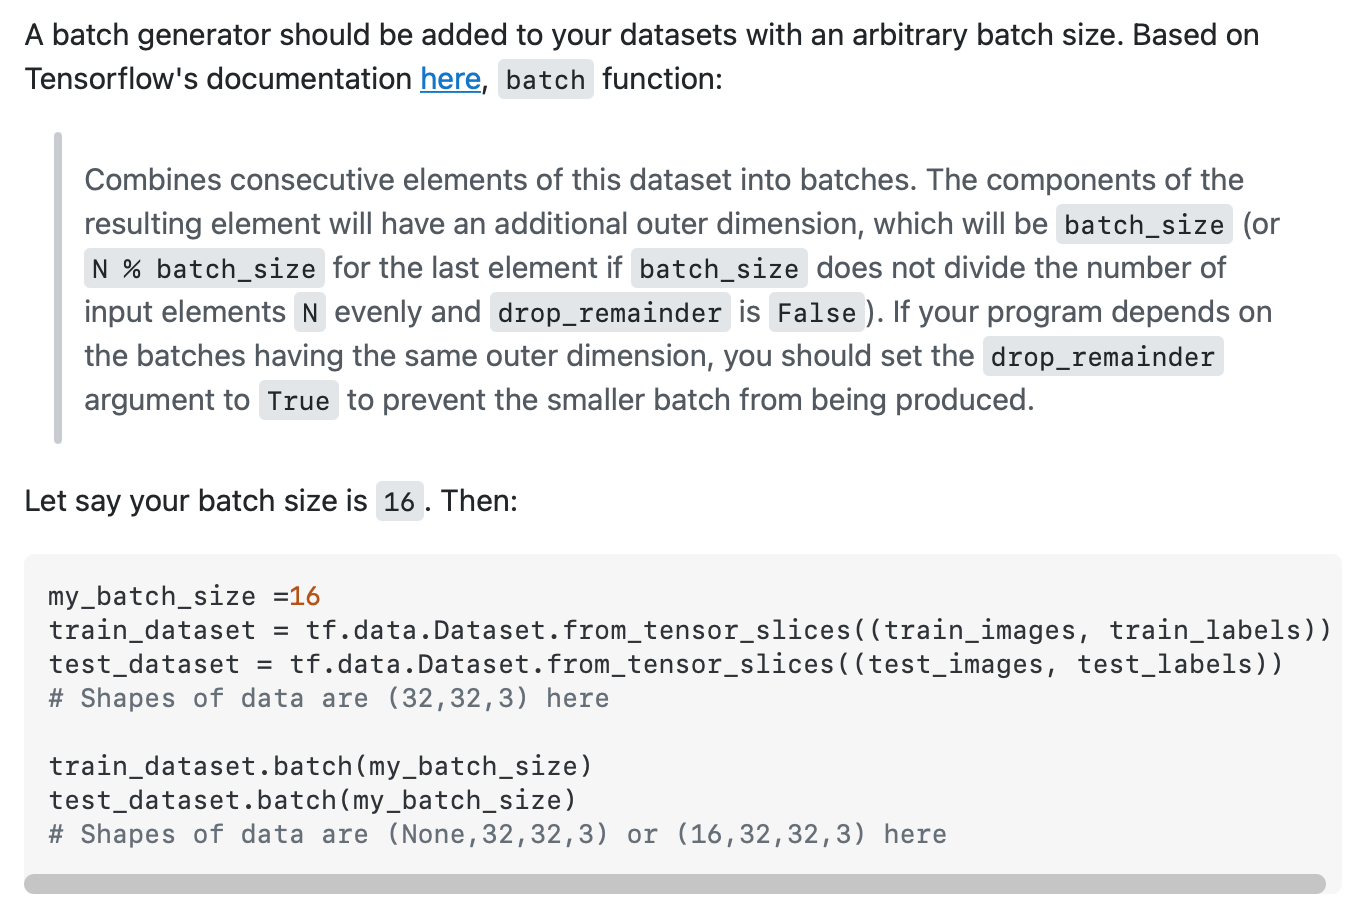

In [7]:
# For perfect shuffling, set the buffer size equal to the full size of the dataset. 
BUFFER_SIZE = len(train_images)
# Define size of batch
BATCH_SIZE = 256 

Lesson learned (if I understood the context correctly): 

Since we want our training dataset splitted into 256 batches, we need to temporarily 

1. slice 4D Tensor(whole data) to 3D 
2. shuffle the data 
3. split the data and insert into different batches [each with size of 256 = len(batch) = 256] 

🪄 this will make 3D to 4D Tensor again (256, : , : ,1) , so that we can use them as input data for our model!  

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator model

Now it is time to generate our two networks 

1. generator model
2. discriminator model

Explanations to model layers coming up later. For now, we will just look at the model framework itself.

In [9]:
def make_generative_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == (None,7,7,256) # assert 예외처리랑 비슷하지만 어떤 조건이 True임을 보증하기 위해서 사용. 이 조건이 참일때 코드는 보장한다는 의미

  model.add(layers.Conv2DTranspose(128,(5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None,28,28,1)

  return model

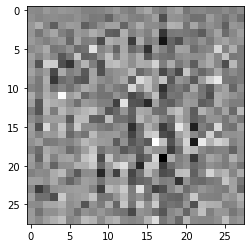

In [10]:
# Create new generator instance 
generator = make_generative_model()

# Random distribution 
noise = tf.random.normal([1,100])

# Get output , freeze layers 
generated_image = generator(noise,training=False)

# Show the output, this output image is not trained at all 
plt.imshow(generated_image[0,:,:,0], cmap='gray')

## Discriminator model

In [11]:
# Convolutional Neural Network, CNN based 
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Since discrimnator has to choose between 'Fake' and 'Real'

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00082867]], shape=(1, 1), dtype=float32)


## Loss function

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Loss function for discriminator

In [14]:
# calculate loss for the real image and loss for the fake image - sum the total loss  
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
     

### Loss function for generator

In [15]:
# (gan 안에서 판별자는 동결되기 때문에 생성자만 업데이트) 결국 생성자는 판별자를 속이도록 훈련
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)   

## Checkpoints
To store all relevant metadata. Information will be gathered into a tf.train.Checkpoint object. 

In [17]:
checkpoint_dir = './GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #ckpt format
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator) 

## Train

In [18]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    '''TensorFlow provides the tf.GradientTape API for automatic differentiation; 
    that is, computing the gradient of a computation with respect to some inputs, 
    usually tf.Variables. TensorFlow "records" relevant operations executed inside 
    the context of a tf.GradientTape onto a "tape".'''

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # generator generate a fake image 

      real_output = discriminator(images, training=True) #train discriminator with real image
      fake_output = discriminator(generated_images, training=True) #train discriminator with fake image

      #calculate loss
      gen_loss = generator_loss(fake_output) 
      disc_loss = discriminator_loss(real_output, fake_output)

    #calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #backpropagation - update weights 
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save model after every 15 epochs 
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # training=False : (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') #denormalize 
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


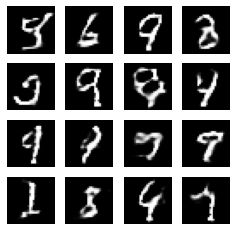

CPU times: user 2min 27s, sys: 25.9 s, total: 2min 52s
Wall time: 12min 17s


In [22]:
%%time
train(train_dataset,EPOCHS)

## Result 

In [23]:
# 마지막 체크포인트를 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [24]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

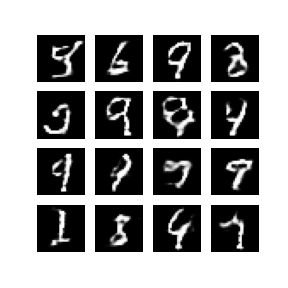

In [31]:
display_image(50)